In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark

import os
import functools as reduce
from pyspark.context import SparkContext
from pyspark.sql import DataFrame, SQLContext, SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

conf = pyspark.SparkConf().setAppName('CTR Prediction').setMaster('local')
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [2]:
spark

In [3]:
"""
Dataset Link:
    https://raw.githubusercontent.com/JaiAhuja/Datasets/main/Analytics%20Using%20PySpark/ctr_traindata2.csv
"""

'\nDataset Link:\n    https://raw.githubusercontent.com/JaiAhuja/Datasets/main/Analytics%20Using%20PySpark/ctr_traindata2.csv\n'

In [4]:
# Reading the dataset
df = spark.read.csv(r"D:\Data Science\IIITB\Data Engineering - II\Module - 6 (Analytics Using PySpark)\3. Logistic Regression Using PySpark\ctr_traindata2.csv", header=True, inferSchema=True)
df.printSchema()

root
 |-- id: decimal(20,0) (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)



In [5]:
df.show()

+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
| 1000009418151094273|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|10000169349117863715|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    

In [6]:
df.columns

['id',
 'click',
 'hour',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

In [7]:
df.head(5)

[Row(id=Decimal('1000009418151094273'), click=0, hour=14102100, C1=1005, banner_pos=0, site_id='1fbe01fe', site_domain='f3845767', site_category='28905ebd', app_id='ecad2386', app_domain='7801e8d9', app_category='07d7df22', device_id='a99f214a', device_ip='ddd2926e', device_model='44956a24', device_type=1, device_conn_type=2, C14=15706, C15=320, C16=50, C17=1722, C18=0, C19=35, C20=-1, C21=79),
 Row(id=Decimal('10000169349117863715'), click=0, hour=14102100, C1=1005, banner_pos=0, site_id='1fbe01fe', site_domain='f3845767', site_category='28905ebd', app_id='ecad2386', app_domain='7801e8d9', app_category='07d7df22', device_id='a99f214a', device_ip='96809ac8', device_model='711ee120', device_type=1, device_conn_type=0, C14=15704, C15=320, C16=50, C17=1722, C18=0, C19=35, C20=100084, C21=79),
 Row(id=Decimal('10000371904215119486'), click=0, hour=14102100, C1=1005, banner_pos=0, site_id='1fbe01fe', site_domain='f3845767', site_category='28905ebd', app_id='ecad2386', app_domain='7801e8d9',

In [8]:
# Removing columns which are String and not required
df_selected = df.select("click", "C1", "banner_pos", "device_type", "device_conn_type", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21")

In [9]:
df_selected.head()

Row(click=0, C1=1005, banner_pos=0, device_type=1, device_conn_type=2, C14=15706, C15=320, C16=50, C17=1722, C18=0, C19=35, C20=-1, C21=79)

In [10]:
df_selected.show()

+-----+----+----------+-----------+----------------+-----+---+---+----+---+---+------+---+
|click|  C1|banner_pos|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+-----+----+----------+-----------+----------------+-----+---+---+----+---+---+------+---+
|    0|1005|         0|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|    0|1005|         0|          1|               0|15704|320| 50|1722|  0| 35|100084| 79|
|    0|1005|         0|          1|               0|15704|320| 50|1722|  0| 35|100084| 79|
|    0|1005|         0|          1|               0|15706|320| 50|1722|  0| 35|100084| 79|
|    0|1005|         1|          1|               0|18993|320| 50|2161|  0| 35|    -1|157|
|    0|1005|         0|          1|               0|16920|320| 50|1899|  0|431|100077|117|
|    0|1005|         0|          1|               0|20362|320| 50|2333|  0| 39|    -1|157|
|    0|1005|         1|          1|               0|20632|320| 50|2374|  3| 39|    -1| 23|

In [11]:
df_selected.select("click").distinct().show()

+-----+
|click|
+-----+
|    1|
|    0|
+-----+



In [12]:
df_selected.groupby("click").count().show()

+-----+-----+
|click|count|
+-----+-----+
|    1|17490|
|    0|82509|
+-----+-----+



In [13]:
df_selected.agg(countDistinct("click")).show()

+------------+
|count(click)|
+------------+
|           2|
+------------+



In [14]:
df_selected.agg(*(countDistinct(col(c)).alias(c) for c in df_selected.columns)).show()

+-----+---+----------+-----------+----------------+---+---+---+---+---+---+---+---+
|click| C1|banner_pos|device_type|device_conn_type|C14|C15|C16|C17|C18|C19|C20|C21|
+-----+---+----------+-----------+----------------+---+---+---+---+---+---+---+---+
|    2|  6|         5|          4|               4|420|  5|  6|128|  4| 37|137| 29|
+-----+---+----------+-----------+----------------+---+---+---+---+---+---+---+---+



In [15]:
# Since, many columns will be created in One Hot Encoding. Therefore, avoiding the columns with huge distinct counts
df_filtered = df_selected.select(["click", "C1", "banner_pos", "device_type", "device_conn_type", "C15", "C16", "C18"])

In [16]:
df_filtered.show()

+-----+----+----------+-----------+----------------+---+---+---+
|click|  C1|banner_pos|device_type|device_conn_type|C15|C16|C18|
+-----+----+----------+-----------+----------------+---+---+---+
|    0|1005|         0|          1|               2|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         1|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         1|          1|               0|320| 50|  3|
|    1|1005|         0|          1|               2|320| 50|  0|
|    0|1002|         0|          0|               0|320| 50|  3|
|    0|1005|         1|          1|               0|320| 50|  2|
|    0|1005|         0|          1|               0|320| 50|  0|
|    0|1005|         0|  

In [17]:
df_filtered.agg(*(countDistinct(col(c)).alias(c) for c in df_filtered.columns)).show()

+-----+---+----------+-----------+----------------+---+---+---+
|click| C1|banner_pos|device_type|device_conn_type|C15|C16|C18|
+-----+---+----------+-----------+----------------+---+---+---+
|    2|  6|         5|          4|               4|  5|  6|  4|
+-----+---+----------+-----------+----------------+---+---+---+



In [18]:
df_filtered.printSchema()

root
 |-- click: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C18: integer (nullable = true)



### Data Preparation

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder

In [20]:
OHE = OneHotEncoder(inputCols=['C1', 'banner_pos', 'device_type', 'device_conn_type','C15', 'C16', 'C18'],
                    outputCols=['C1_encoded', 'banner_pos_encoded', 'device_type_encoded', 'device_conn_type_encoded', 'C15_encoded','C16_encoded', 'C18_encoded'])

In [21]:
# Vector Assembler
vec_assembler = VectorAssembler(inputCols=['C1_encoded', 'banner_pos_encoded', 'device_type_encoded', 'device_conn_type_encoded', 'C15_encoded','C16_encoded', 'C18_encoded'],
                               outputCol="features")

In [22]:
# Pipeline
final_pipeline = Pipeline(stages=[OHE, vec_assembler])

In [23]:
piped_data = final_pipeline.fit(df_filtered).transform(df_filtered)
piped_data.show()

+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|click|  C1|banner_pos|device_type|device_conn_type|C15|C16|C18|device_type_encoded|     C16_encoded|banner_pos_encoded|  C18_encoded|         C1_encoded|device_conn_type_encoded|      C15_encoded|            features|
+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|    0|1005|         0|          1|               2|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[0],[1.0])|(1010,[1005],[1.0])|           (5,[2],[1.0])|(728,[320],[1.0])|(2236,[1005,1010,...|
|    0|1005|         0|          1|               0|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[

In [24]:
piped_data.columns

['click',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C15',
 'C16',
 'C18',
 'device_type_encoded',
 'C16_encoded',
 'banner_pos_encoded',
 'C18_encoded',
 'C1_encoded',
 'device_conn_type_encoded',
 'C15_encoded',
 'features']

In [25]:
piped_dataset = piped_data.withColumnRenamed("click", "label")
piped_dataset.show(10)

+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|label|  C1|banner_pos|device_type|device_conn_type|C15|C16|C18|device_type_encoded|     C16_encoded|banner_pos_encoded|  C18_encoded|         C1_encoded|device_conn_type_encoded|      C15_encoded|            features|
+-----+----+----------+-----------+----------------+---+---+---+-------------------+----------------+------------------+-------------+-------------------+------------------------+-----------------+--------------------+
|    0|1005|         0|          1|               2|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[0],[1.0])|(1010,[1005],[1.0])|           (5,[2],[1.0])|(728,[320],[1.0])|(2236,[1005,1010,...|
|    0|1005|         0|          1|               0|320| 50|  0|      (5,[1],[1.0])|(480,[50],[1.0])|     (5,[0],[1.0])|(3,[

In [26]:
# Since, we only need label and features column for model building. Hence, trimming the dataframe.
model_data = piped_dataset.select(["label", "features"])
model_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1011,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1011,...|
|    1|(2236,[1005,1010,...|
|    0|(2236,[1002,1010,...|
|    0|(2236,[1005,1011,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1010,...|
|    0|(2236,[1005,1011,...|
|    0|(2236,[1005,1010,...|
+-----+--------------------+
only showing top 20 rows



## Model Building

In [27]:
# Separating train and test data
training, test = model_data.randomSplit([0.7, 0.3])

In [28]:
training.count()

69744

#### Logistic Regression Model

In [29]:
from pyspark.ml.classification import LogisticRegression

In [30]:
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [31]:
model = lr.fit(training)

### Model Evaluation

In [32]:
# Printing the Coefficients and intercept for the model
print("Coefficients: " +str(model.coefficients))
print("Intercept: " +str(model.intercept))

Coefficients: (2236,[1001,1002,1005,1007,1008,1010,1011,1012,1014,1015,1016,1019,1020,1022,1023,1145,1241,1325,1345,1773,1789,1803,1843,2003,2233,2234,2235],[0.5084430539343735,0.44706256500605124,0.4155065354654476,-13.787772690565134,1.6045546289205197,-0.1749219222769804,0.026211332632161577,0.09164349457020135,0.2835101107867058,0.44706256500605124,0.22686576493339045,-0.2797231421656145,0.6501126409686692,0.5635683027267762,0.2584208939275093,-7.4716547359452585,-0.6120506823985356,8.451234335111373e-05,-0.33762790399097153,-7.4716547359452585,-0.6120506823985356,-1.0828990274639683,-15.05582010095583,-0.6170673777643928,0.14320158752633483,-0.7884367769369889,1.0154466801490944])
Intercept: -1.57066164914022


In [33]:
#### Plotting ROC curve

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

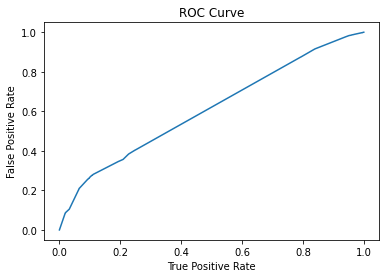

In [35]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc["FPR"], roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [36]:
print("Training set areaUnderCurve: " + str(trainingSummary.areaUnderROC))

Training set areaUnderCurve: 0.60905103149969


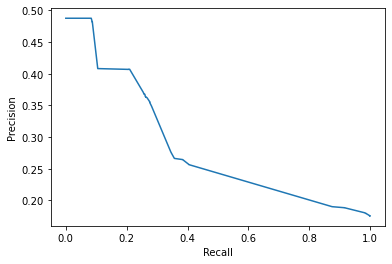

In [37]:
# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr["recall"], pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

### Accuracy

In [38]:
summary = model.evaluate(test)

In [39]:
summary.accuracy

0.8264088580399934

In [40]:
output = model.transform(test)
output.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(2236,[1001,1010,...|[1.78068904303570...|[0.85578192791284...|       0.0|
|    0|(2236,[1001,1010,...|[1.78068904303570...|[0.85578192791284...|       0.0|
|    0|(2236,[1001,1010,...|[1.78068904303570...|[0.85578192791284...|       0.0|
|    0|(2236,[1001,1010,...|[1.78068904303570...|[0.85578192791284...|       0.0|
|    0|(2236,[1001,1010,...|[1.8672333812776,...|[0.86613783195285...|       0.0|
|    0|(2236,[1001,1010,...|[1.8672333812776,...|[0.86613783195285...|       0.0|
|    0|(2236,[1001,1010,...|[1.8672333812776,...|[0.86613783195285...|       0.0|
|    0|(2236,[1001,1010,...|[1.8672333812776,...|[0.86613783195285...|       0.0|
|    0|(2236,[1002,1010,...|[1.42544716523350...|[0.80619094001715...|       0.0|
|    0|(2236,[10

In [41]:
output.select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



#### ROC

In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [43]:
evaluator = BinaryClassificationEvaluator()

In [44]:
print("Test Area Under ROC", evaluator.evaluate(output))

Test Area Under ROC 0.6070288739760977


##### For Testing purposes, let's now remove any column from the dataset except for string and run the model on the same

In [45]:
df_selected = df_selected.select([col for col in df_selected.columns if col != "C20"])

root
 |-- click: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C21: integer (nullable = true)

+-----+----+----------+-----------+----------------+-----+---+---+----+---+---+---+-------------------+----------------+--------------------+------------------+-------------------+------------------+-------------+-------------------+-----------------+------------------------+-----------------+--------------------+
|click|  C1|banner_pos|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|C21|device_type_encoded|     C16_encoded|         C14_encoded|banner_pos_encoded|        C17_encoded|       C19_encoded|  C18_encoded|    

Training Count:70072
Coefficients: (28430,[1001,1002,1005,1007,1008,1010,1011,1012,1014,1015,1016,1019,1020,1022,1023,1400,1402,1405,1406,1477,1479,1481,1488,1812,2062,2063,2064,2291,2292,2293,2294,2295,2297,2300,2301,2303,5432,5543,5712,7385,7386,7387,7389,7390,7391,7417,7418,7422,7423,7424,7582,7583,7584,7585,7588,7641,8015,8016,8017,8018,8049,8718,8719,8720,10019,10020,10273,10461,10463,10486,10503,10823,10828,10830,13018,13019,13021,13025,13029,13033,13037,13041,13046,13051,13066,13068,13228,13238,13251,13259,13494,13495,13496,13497,13502,14668,14669,14803,14804,14805,14807,14808,15167,16008,16010,16013,16030,16031,16035,16041,16042,16415,16565,16567,16568,16569,16570,16571,16573,16574,16575,16576,16723,16724,16725,16726,16727,16728,16729,16730,16731,16732,16733,16854,16933,17036,17095,17096,17178,17233,17288,17428,17430,17431,17432,17433,17640,17710,17712,17863,17866,17883,17884,17945,18014,18039,18051,18062,18106,18188,18237,18264,18287,18288,18289,18598,18608,18611,18639,18678,1

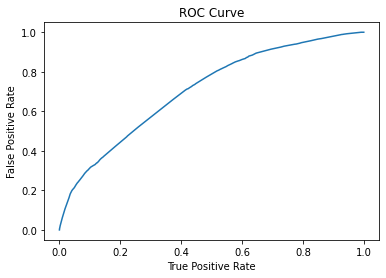

Training set areaUnderCurve: 0.7067127829262968


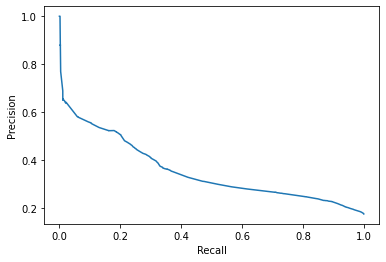

Accuracy on Test Set:0.8270792261168844
+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|(28430,[1001,1010...|[2.60122889860653...|[0.93094062761615...|       0.0|
|    0|(28430,[1001,1010...|[2.58148523507925...|[0.92966045344316...|       0.0|
|    0|(28430,[1001,1010...|[2.58148523507925...|[0.92966045344316...|       0.0|
|    0|(28430,[1001,1010...|[2.58148523507925...|[0.92966045344316...|       0.0|
|    0|(28430,[1001,1010...|[2.58148523507925...|[0.92966045344316...|       0.0|
|    0|(28430,[1001,1010...|[2.58148523507925...|[0.92966045344316...|       0.0|
|    0|(28430,[1001,1010...|[2.51160054510071...|[0.92495107049290...|       0.0|
|    0|(28430,[1001,1010...|[2.49185688157344...|[0.92356898178843...|       0.0|
|    0|(28430,[1001,1010...|[2.49185688157344...|[0.923568

In [46]:
df_selected.printSchema()

# ### Data Preparation
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder

OHE = OneHotEncoder(inputCols=[col for col in df_selected.columns if col not in ["click", "C20"]],
                    outputCols=[col+str("_encoded") for col in df_selected.columns if col not in ["click", "C20"]])

# Vector Assembler
vec_assembler = VectorAssembler(inputCols=[col+str("_encoded") for col in df_selected.columns if col not in ["click", "C20"]],
                               outputCol="features")

# Pipeline
final_pipeline = Pipeline(stages=[OHE, vec_assembler])

piped_data = final_pipeline.fit(df_selected).transform(df_selected)
piped_data.show()

piped_data.columns

piped_dataset = piped_data.withColumnRenamed("click", "label")

# Since, we only need label and features column for model building. Hence, trimming the dataframe.
model_data = piped_dataset.select(["label", "features"])
model_data.show()

# ## Model Building

# Separating train and test data
training, test = model_data.randomSplit([0.7, 0.3])

print("Training Count:" +str(training.count()))

# #### Logistic Regression Model

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label")

model = lr.fit(training)

# ### Model Evaluation
# Printing the Coefficients and intercept for the model
print("Coefficients: " +str(model.coefficients))
print("Intercept: " +str(model.intercept))

#### Plotting ROC curve

import matplotlib.pyplot as plt
%matplotlib inline

trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc["FPR"], roc["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

print("Training set areaUnderCurve: " + str(trainingSummary.areaUnderROC))

# Precision Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr["recall"], pr["precision"])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()


# ### Accuracy

summary = model.evaluate(test)

print("Accuracy on Test Set:" +str(summary.accuracy))

output = model.transform(test)
output.show()

output.select("label", "prediction").show()

# #### ROC

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

print("Test Area Under ROC", evaluator.evaluate(output))

`Note:` We can see that the accurcy when we select all the columns in a little bit higher than the previous run